In [1]:
import cv2
import os
import time
import numpy as np
import tensorflow as tf
import time
import collections
import PIL
from tensorflow.python.framework import graph_io
from tensorflow.keras.models import load_model
from tqdm import tqdm_notebook as tqdm
import tensorflow.contrib.tensorrt as trt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
input_names = ['input_1_1'] 

output_names = ['conv2d_13_1/Sigmoid']

In [3]:
def get_frozen_graph(graph_file):
    """Read Frozen Graph file from disk."""
    with tf.gfile.GFile(graph_file, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 506741647089506655
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12334508074453617430
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17683981171401479129
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1900015616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5528615890959365241
physical_device_desc: "device: 0, name: NVIDIA Tegra X2, pci bus id: 0000:00:00.0, compute capability: 6.2"
]


In [5]:
DEVICE = "/device:GPU:0"

# Create session and load graph
tf_config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
tf_config.gpu_options.allow_growth = True
tf_sess = tf.Session(config=tf_config)

# TRT

In [6]:
frozen_graph = get_frozen_graph('../models/unet_no_compile_model.pb')

In [7]:
tf.keras.backend.set_learning_phase(0)

In [8]:
with tf.device(DEVICE):
    tf.import_graph_def(frozen_graph, name='')

In [9]:
import tensorflow.contrib.tensorrt as trt

trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    #is_dynamic_op=True,
    #maximum_cached_engines=1,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=1
)

INFO:tensorflow:Linked TensorRT version: (5, 1, 6)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 6)
INFO:tensorflow:Running against TensorRT version 5.1.6


In [10]:
# Get graph input size
for node in trt_graph.node:
    if 'input_' in node.name:
        size = node.attr['shape'].shape
        image_size = [size.dim[i].size for i in range(1, 4)]
        break
print("image_size: {}".format(image_size))

image_size: [384, 640, 3]


In [11]:
graph_io.write_graph(trt_graph, "../models/",
                     "unet_no_compile_model_trt_tx2.pb", as_text=False)

'../models/unet_no_compile_model_trt_tx2.pb'

In [6]:
trt_graph = get_frozen_graph('../models/unet_no_compile_model_trt_tx2.pb')
tf.import_graph_def(trt_graph, name='')

In [7]:
writer = tf.summary.FileWriter('../logs')
writer.add_graph(tf_sess.graph)

In [8]:
#image = cv2.imread('/home/jetson/Pictures/img_000000.png')
image = cv2.imread('../two_images/0_2019-01-31-15-49-59_kia_velo_gps_time_stereo_leftimg_000530.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [9]:
image = cv2.resize(image, (640, 384))

In [10]:
image = image[None,:, :, :] / 255

In [11]:
image.shape

(1, 384, 640, 3)

In [12]:
input_image = tf_sess.graph.get_tensor_by_name("input_1_1:0")
output = tf_sess.graph.get_tensor_by_name("conv2d_13_1/Sigmoid:0")
feed = {input_image:image}

In [25]:
%%timeit
result = tf_sess.run(output, feed_dict=feed)

183 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
%%time
result = tf_sess.run(output, feed_dict=feed)[0]

CPU times: user 20 ms, sys: 12 ms, total: 32 ms
Wall time: 184 ms


In [31]:
result.shape

(384, 640, 12)

In [32]:
import matplotlib.pyplot as plt
import numpy as np

In [33]:
import sys
sys.path.append("../")

In [34]:
color_mask_dict = {
        "traffic_sign": "00ffff",
        "animal": "ccff99",  # -
        "bicycle": "b65906",  # -
        "bus": "ffff00",  # not in audi #-
        "car": "ff0000",
        "double_solid": "ffc1ff",  # not in audi
        "intermittent": "8000ff",
        "motorcycle": "5a1e1e",  # not in audi #-
        "person": "cc99ff",
        "solid": "ffc125",
        "solid_mixed": "ffc1bb",  # -
        "stop_lane": "8055ff",
        "temporary": "80aaff",  # -
        "traffic_light": "0080ff",
        "train": "ffffc8",  # not in audi #-
        "truck": "ff8000",
        "borders": "b496c8",  # not in audi
        "road": "ff00ff",
        "sky": "87ceff"
    }

label_list = ["traffic_sign",
              "car","truck",
              "person",
              "solid", "double_solid", "intermittent", "stop_lane",
              "traffic_light",
              "borders",
              "road",
              "sky"]
def convert_str_to_rgb(str_value):
    return (int(str_value[4:6], 16), int(str_value[2:4], 16), int(str_value[0:2], 16)) #in bgr format

In [35]:
img = np.argmax(result, axis=2) * (255 / 12)

In [36]:
num_class = 12
img_out = np.zeros((result.shape[0], result.shape[1], 3), dtype=np.uint8)
for i in range(num_class):
    idx = num_class-1-i
    label_color = convert_str_to_rgb(color_mask_dict[label_list[idx]])
    mask = result[:,:,idx]
    img_out[mask > 0.1] = np.array(label_color)

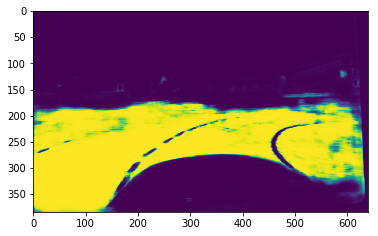

In [37]:
plt.imshow(result[:,:,10])

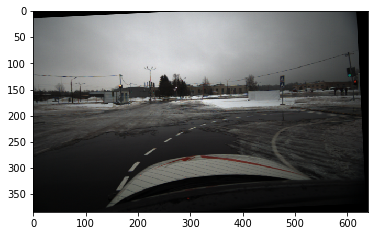

In [38]:
plt.imshow(image[0])

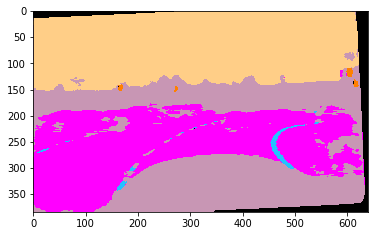

In [39]:
plt.imshow(img_out)

In [40]:
img_out.shape

(384, 640, 3)